1. Department 근무 부서  

Attrition 이직 여부  
------------- 부서 특성 ------------- 에 맞는 직원 채용 전략
Age 나이  
EmployeeCount 직원 수  
Education 교육 수준  
EducationField 전공 분야  
JobLevel 직급 수준  
JobRole 직무 역할  
MaritalStatus 결혼 상태  
NumCompaniesWorked 이전 근무한 회사 수  
Over18 만 18세 이상 여부  

Gender 성별  
EmployeeNumber 직원 번호  

------------- 업무 난이도 ------------- 난이도 개선을 통한 이직률 감소 전략
BusinessTravel 출장 빈도  
EnvironmentSatisfaction 근무 환경 만족도  
JobInvolvement 직무 몰입도  
JobSatisfaction 직무 만족도  
OverTime 초과 근무 여부  
PerformanceRating 성과 평가  
StandardHours 표준 근무 시간  

------------- 복지 ------------- 복지 혜택을 위한 이직률 감소 전략
DailyRate 하루 급여  
HourlyRate 시간당 급여  
DistanceFromHome 집과 회사 사이 거리  
MonthlyIncome 월급  
MonthlyRate 월급 지급률  
PercentSalaryHike 연봉 인상률  
RelationshipSatisfaction 대인 관계 만족도  
StockOptionLevel 스톡옵션 수준  
TrainingTimesLastYear 연간 교육 참여 횟수  
WorkLifeBalance 일과 삶의 균형 만족도  



TotalWorkingYears 총 근속 연수  // 전체 커리어 연수
YearsAtCompany 회사 근속 연수  // 이 회사 커리어 연수
YearsInCurrentRole 현재 직무에서의 근속 연수  // 총 직무에서 연수 (직무 변경 사례)
YearsSinceLastPromotion 마지막 승진 이후 경과 연수  // 진급 지연 연수
YearsWithCurrManager 현재 상사와 함께 근무한 연수  // 상사가 자주 바뀌는 정도

In [64]:
# -----------------------------
# 1. 라이브러리 불러오기
# -----------------------------
import pandas as pd

# -----------------------------
# 2. 데이터 불러오기
# -----------------------------
# CSV 파일이 같은 폴더에 있다고 가정
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# -----------------------------
# 3. 이직 여부 숫자화 (Yes=1, No=0)
# -----------------------------
df["Attrition_Flag"] = df["Attrition"].map({"Yes":1, "No":0})




In [65]:
# -----------------------------
# 4. 부서별 평균 계산
# -----------------------------
# 평균을 낼 수 있는 수치형 변수 자동 선택
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns

# Department별 평균 집계
dept_means = df.groupby("Department")[numeric_cols].mean().round(2)

# -----------------------------
# 5. 결과 출력
# -----------------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("부서별 각 변수의 평균값")
print(dept_means)

# -----------------------------
# 6. CSV로 저장 (선택사항)
# -----------------------------
dept_means.to_csv("department_means.csv")

부서별 각 변수의 평균값
                          Age  DailyRate  DistanceFromHome  Education  \
Department                                                              
Human Resources         37.81     751.54              8.70       2.97   
Research & Development  37.04     806.85              9.14       2.90   
Sales                   36.54     800.28              9.37       2.93   

                        EmployeeCount  EmployeeNumber  \
Department                                              
Human Resources                   1.0         1205.27   
Research & Development            1.0         1006.50   
Sales                             1.0         1038.95   

                        EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Department                                                                    
Human Resources                            2.68       64.30            2.75   
Research & Development                     2.74       66.17            2.74   
Sales             

In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1) Mac / Linux / Windows 공통적으로 적용 가능
plt.rcParams['font.family'] = 'AppleGothic'   # Mac: 애플고딕
# plt.rcParams['font.family'] = 'NanumGothic'   # 리눅스: 나눔고딕

# 2) 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False


In [67]:
import pandas as pd
import statsmodels.api as sm

# 1. 이직 여부 숫자화
df["Attrition_Flag"] = df["Attrition"].map({"Yes": 1, "No": 0})

# 2. 독립 변수 (ID/상수 변수 제외)
features = [
    "Age","BusinessTravel","DailyRate","DistanceFromHome","Education",
    "EducationField","Gender","HourlyRate","JobInvolvement","JobLevel","JobRole",
    "MaritalStatus","MonthlyIncome","MonthlyRate","NumCompaniesWorked","OverTime",
    "PercentSalaryHike","PerformanceRating","RelationshipSatisfaction",
    "StockOptionLevel","TotalWorkingYears","TrainingTimesLastYear","WorkLifeBalance",
    "YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion","YearsWithCurrManager"
]

# 결과 저장 리스트
all_results = []

# 3. 부서별 반복
for dept in df["Department"].unique():
    print("="*60)
    print(f"[Department: {dept}]")

    df_sub = df[df["Department"] == dept].copy()
    y = df_sub["Attrition_Flag"]

    # 범주형 변수 원핫 인코딩
    X = pd.get_dummies(df_sub[features], drop_first=True).astype(float)

    try:
        model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)

        summary_table = pd.DataFrame({
            "coef": model.params,
            "std_err": model.bse,
            "z": model.tvalues,
            "p_value": model.pvalues,
            "CI_lower": model.conf_int()[0],
            "CI_upper": model.conf_int()[1]
        })

        # p-value < 0.05 필터링
        sig_vars = summary_table[summary_table["p_value"] < 0.05].sort_values("p_value")

        if sig_vars.empty:
            print(" ➝ 유의미한 변수 없음 (p < 0.05)")
            empty_df = pd.DataFrame({
                "Department": [dept],
                "Variable": ["None"],
                "coef": [None],
                "std_err": [None],
                "z": [None],
                "p_value": [None],
                "CI_lower": [None],
                "CI_upper": [None]
            })
            all_results.append(empty_df)
        else:
            print(sig_vars)
            sig_vars = sig_vars.reset_index().rename(columns={"index": "Variable"})
            sig_vars.insert(0, "Department", dept)
            all_results.append(sig_vars)

    except Exception as e:
        print(f"모델 오류 발생: {e}")
        error_df = pd.DataFrame({
            "Department": [dept],
            "Variable": ["Error"],
            "coef": [None],
            "std_err": [None],
            "z": [None],
            "p_value": [None],
            "CI_lower": [None],
            "CI_upper": [None]
        })
        all_results.append(error_df)

# 4. 하나의 DataFrame으로 합치기
final_df = pd.concat(all_results, ignore_index=True)

# 5. CSV 저장
final_df.to_csv("dept_attrition_significant_vars.csv", index=False, encoding="utf-8-sig")

print("\nCSV 파일 저장 완료: dept_attrition_significant_vars.csv")
print(final_df)


[Department: Sales]
                                      coef   std_err         z       p_value  \
OverTime_Yes                      2.008741  0.342238  5.869435  4.372840e-09   
JobInvolvement                   -0.699896  0.207009 -3.380997  7.222339e-04   
BusinessTravel_Travel_Frequently  2.335226  0.701399  3.329383  8.703854e-04   
NumCompaniesWorked                0.224322  0.068255  3.286511  1.014369e-03   
JobRole_Sales Representative      3.944140  1.357239  2.906003  3.660785e-03   
DistanceFromHome                  0.053660  0.019051  2.816691  4.852119e-03   
MaritalStatus_Single              1.551162  0.624447  2.484058  1.298948e-02   
YearsSinceLastPromotion           0.141638  0.067312  2.104193  3.536163e-02   
BusinessTravel_Travel_Rarely      1.275033  0.645647  1.974814  4.828922e-02   

                                  CI_lower  CI_upper  
OverTime_Yes                      1.337968  2.679515  
JobInvolvement                   -1.105626 -0.294166  
BusinessTravel

/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/var/folders/t9/jtcjl9f16bg9_stl74jgcyvr0000gn/T/ipykernel_33333/686595262.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_results, ignore_index=True)


In [68]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # -----------------------------
# # 1) 부서별 직원 수 분포
# # -----------------------------
# dept_counts = df["Department"].value_counts()
# plt.figure(figsize=(6,6))
# plt.pie(
#     dept_counts,
#     labels=dept_counts.index,
#     autopct='%1.1f%%',
#     startangle=90,
#     colors=sns.color_palette("Set2", len(dept_counts))
# )
# plt.title("부서별 직원 수 분포")
# plt.show()



# # -----------------------------
# # 3) 부서별 평균 월급
# # -----------------------------
# dept_income = df.groupby("Department")["MonthlyIncome"].mean().sort_values()
# plt.figure(figsize=(8,5))
# sns.barplot(x=dept_income.index, y=dept_income.values, palette="Blues_d")
# plt.title("부서별 평균 월급")
# plt.ylabel("월급 평균")
# plt.show()

# # -----------------------------
# # 4) 부서별 평균 나이
# # -----------------------------
# dept_age = df.groupby("Department")["Age"].mean().sort_values()
# plt.figure(figsize=(8,5))
# sns.barplot(x=dept_age.index, y=dept_age.values, palette="Greens_d")
# plt.title("부서별 평균 나이")
# plt.ylabel("나이 평균")
# plt.show()




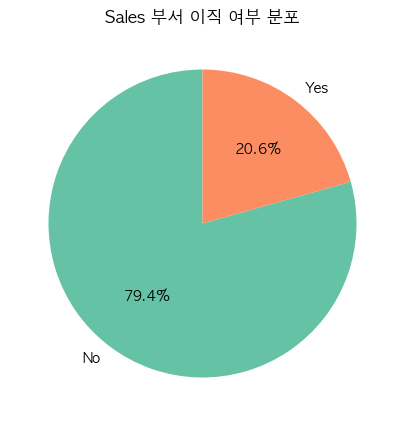

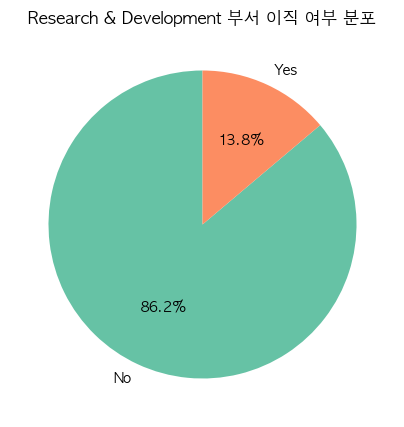

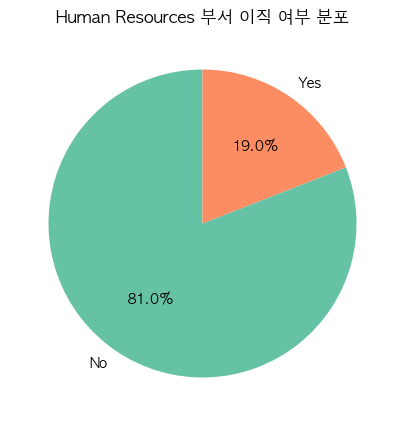

In [69]:
# -----------------------------
# 2) 부서별 이직 여부 분포 (Pie Chart)
# -----------------------------
for dept in df["Department"].unique():
    subset = df[df["Department"] == dept]
    attr_counts = subset["Attrition"].value_counts(normalize=True) * 100

    plt.figure(figsize=(5,5))
    plt.pie(
        attr_counts,
        labels=attr_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("Set2", len(attr_counts))
    )
    plt.title(f"{dept} 부서 이직 여부 분포")
    plt.show()

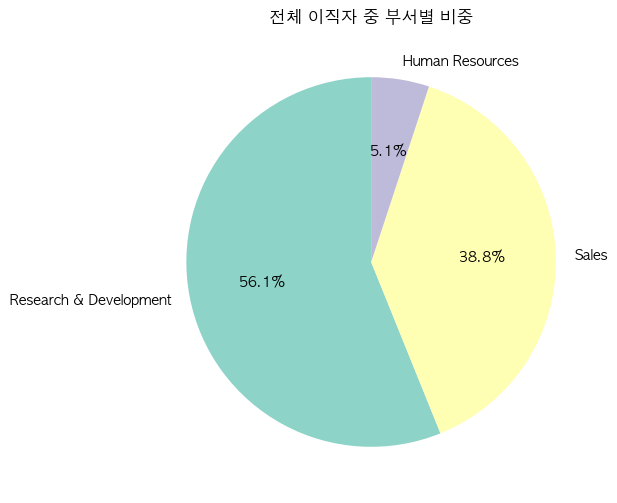

부서별 이직자 비중 (%)
Department
Research & Development    56.118143
Sales                     38.818565
Human Resources            5.063291
Name: proportion, dtype: float64


In [70]:
# 전체 이직자 중 부서별 비중
dept_attrition_counts = df[df["Attrition"]=="Yes"]["Department"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(
    dept_attrition_counts,
    labels=dept_attrition_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3", len(dept_attrition_counts))
)
plt.title("전체 이직자 중 부서별 비중")
plt.show()

print("부서별 이직자 비중 (%)")
print(dept_attrition_counts)


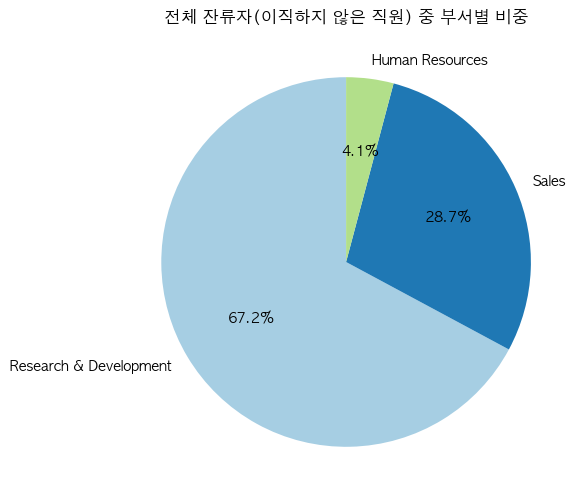

부서별 잔류자 비중 (%)
Department
Research & Development    67.153285
Sales                     28.710462
Human Resources            4.136253
Name: proportion, dtype: float64


In [74]:
# 전체 잔류자(Attrition = No) 중 부서별 비중
dept_retention_counts = df[df["Attrition"]=="No"]["Department"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(
    dept_retention_counts,
    labels=dept_retention_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Paired", len(dept_retention_counts))
)
plt.title("전체 잔류자(이직하지 않은 직원) 중 부서별 비중")
plt.show()

print("부서별 잔류자 비중 (%)")
print(dept_retention_counts)


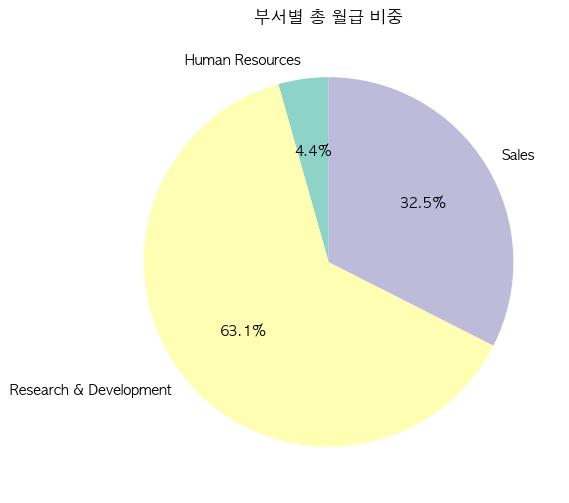

부서별 총 월급 비율 (%)
Department
Human Resources            4.38561
Research & Development    63.14561
Sales                     32.46878
Name: MonthlyIncome, dtype: float64


In [72]:
# 부서별 월급 총액 계산
dept_salary_sum = df.groupby("Department")["MonthlyIncome"].sum()

# 비율 계산 (%)
dept_salary_ratio = dept_salary_sum / dept_salary_sum.sum() * 100

# 원형 차트 시각화
plt.figure(figsize=(6,6))
plt.pie(
    dept_salary_ratio,
    labels=dept_salary_ratio.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3", len(dept_salary_ratio))
)
plt.title("부서별 총 월급 비중")
plt.show()

print("부서별 총 월급 비율 (%)")
print(dept_salary_ratio)


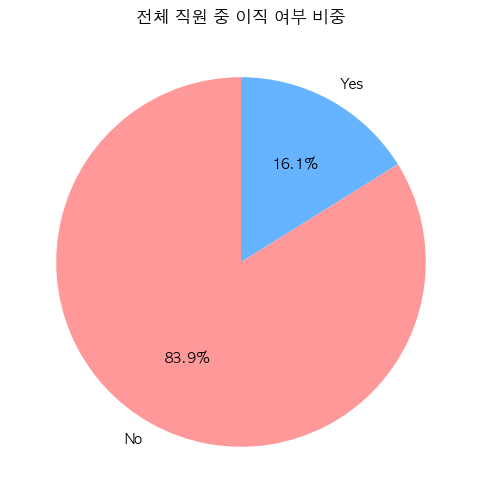

전체 직원 중 이직 여부 비중 (%)
Attrition
No     83.9
Yes    16.1
Name: proportion, dtype: float64


In [82]:
# 전체 이직 여부 비율 계산
attrition_counts = df["Attrition"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(
    attrition_counts,
    labels=attrition_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=["#ff9999","#66b3ff"]
)
plt.title("전체 직원 중 이직 여부 비중")
plt.show()

print("전체 직원 중 이직 여부 비중 (%)")
print(attrition_counts.round(1))


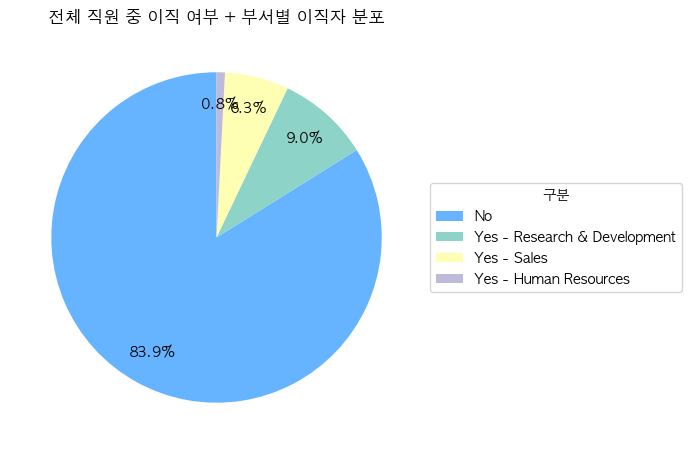

전체 직원 중 이직 여부 + 부서별 이직자 비중 (%)
No                              83.9
Yes - Research & Development     9.0
Yes - Sales                      6.3
Yes - Human Resources            0.8
dtype: float64


In [115]:
# 전체 직원 수
n_total = len(df)

# 이직 NO 비율
no_ratio = (df["Attrition"]=="No").sum() / n_total * 100

# 이직 YES + 부서별 비율
yes_dept_ratio = (
    df[df["Attrition"]=="Yes"]["Department"].value_counts() / n_total * 100
)

# 최종 데이터
sizes = [no_ratio] + yes_dept_ratio.tolist()
labels = ["No"] + [f"Yes - {dept}" for dept in yes_dept_ratio.index]
colors = ["#66b3ff"] + sns.color_palette("Set3", len(yes_dept_ratio))

plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    labeldistance=1.1,   # 라벨 위치 (원 밖)
    pctdistance=0.8,     # 퍼센트 위치 (안쪽)
    textprops={'fontsize':10}
)

# 특정 라벨 위치 조정
for t, lab in zip(texts, labels):
    if "Human Resources" in lab:
        x, y = t.get_position()
        t.set_position((x, y+0.1))   # y 좌표를 살짝 위로 (0.1 ~ 0.2 권장)

# 범례 추가
plt.legend(wedges, labels, title="구분", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("전체 직원 중 이직 여부 + 부서별 이직자 분포")
plt.tight_layout()
plt.show()

# 값 확인
print("전체 직원 중 이직 여부 + 부서별 이직자 비중 (%)")
print(pd.Series(sizes, index=labels).round(1))


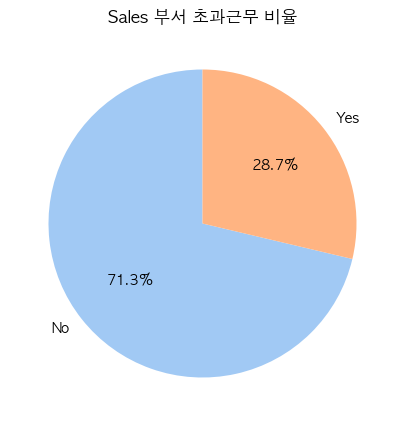

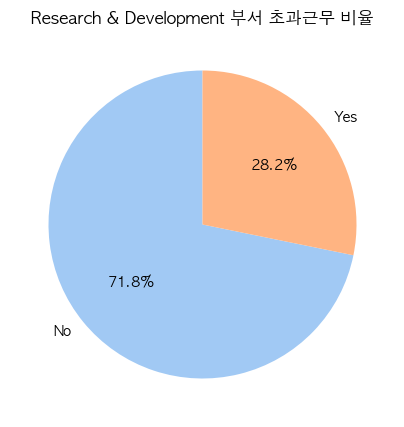

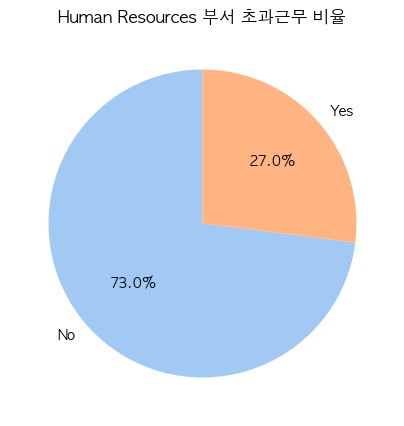

In [ ]:
# -----------------------------
# 5) 부서별 초과근무 비율 (Pie Chart)
# -----------------------------
for dept in df["Department"].unique():
    subset = df[df["Department"] == dept]
    overtime_counts = subset["OverTime"].value_counts(normalize=True) * 100

    plt.figure(figsize=(5,5))
    plt.pie(
        overtime_counts,
        labels=overtime_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(overtime_counts))
    )
    plt.title(f"{dept} 부서 초과근무 비율")
    plt.show()

In [ ]:
# 부서 특성 Feature
dept_features = [#"EmployeeCount",
    "Age","Education","EducationField","JobLevel","JobRole",
    "MaritalStatus","NumCompaniesWorked","Over18","Gender"
]

# 업무 난이도 Feature
workload_features = [
    "BusinessTravel","EnvironmentSatisfaction","JobInvolvement","JobSatisfaction",
    "OverTime","PerformanceRating","StandardHours"
]

# 복지 Feature
welfare_features = [
    "DailyRate","HourlyRate","DistanceFromHome","MonthlyIncome","MonthlyRate",
    "PercentSalaryHike","RelationshipSatisfaction","StockOptionLevel",
    "TrainingTimesLastYear","WorkLifeBalance"
]


In [ ]:
from sklearn.preprocessing import StandardScaler

# 숫자형만 스케일링
scaler = StandardScaler()

# 더미 인코딩
X_dept = pd.get_dummies(df[dept_features], drop_first=True)
X_work = pd.get_dummies(df[workload_features], drop_first=True)
X_welfare = pd.get_dummies(df[welfare_features], drop_first=True)

# 표준화
X_dept_scaled = pd.DataFrame(scaler.fit_transform(X_dept), columns=X_dept.columns)
X_work_scaled = pd.DataFrame(scaler.fit_transform(X_work), columns=X_work.columns)
X_welfare_scaled = pd.DataFrame(scaler.fit_transform(X_welfare), columns=X_welfare.columns)

# 그룹별 합성 Feature (평균 Score)
df["DeptScore"] = X_dept_scaled.mean(axis=1)
df["WorkloadScore"] = X_work_scaled.mean(axis=1)
df["WelfareScore"] = X_welfare_scaled.mean(axis=1)


In [ ]:
import statsmodels.api as sm

y = df["Attrition"].map({"Yes":1,"No":0})
X = df[["DeptScore","WorkloadScore","WelfareScore"]]

model = sm.Logit(y, sm.add_constant(X)).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.431320
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1466
Method:                           MLE   Df Model:                            3
Date:                Wed, 17 Sep 2025   Pseudo R-squ.:                 0.02349
Time:                        13:18:56   Log-Likelihood:                -634.04
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 1.083e-06
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7030      0.074    -22.925      0.000      -1.849      -1.557
DeptScore        -0.

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 1. 이직 여부 숫자화
df["Attrition_Flag"] = df["Attrition"].map({"Yes":1, "No":0})

# 2. 부서별 반복
results = {}
for dept in df["Department"].unique():
    print(f"\n[Department: {dept}]")
    df_sub = df[df["Department"] == dept].copy()
    
    y = df_sub["Attrition_Flag"]
    X = df_sub[["DeptScore", "WorkloadScore", "WelfareScore"]]
    
    try:
        model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
        
        summary_table = pd.DataFrame({
            "coef": model.params,
            "std_err": model.bse,
            "z": model.tvalues,
            "p_value": model.pvalues,
            "CI_lower": model.conf_int()[0],
            "CI_upper": model.conf_int()[1]
        })
        
        # p-value < 0.05만 출력
        sig_vars = summary_table[summary_table["p_value"] < 0.05].sort_values("p_value")
        if sig_vars.empty:
            print("  ➝ 유의미한 변수 없음 (p < 0.05)")
        else:
            print(sig_vars)
            results[dept] = sig_vars
    
    except Exception as e:
        print(f"모델 오류 발생: {e}")



[Department: Sales]
                  coef   std_err          z       p_value  CI_lower  CI_upper
const        -1.373983  0.121631 -11.296344  1.367945e-29 -1.612375 -1.135591
WelfareScore -0.932791  0.387494  -2.407240  1.607362e-02 -1.692266 -0.173317

[Department: Research & Development]
                  coef   std_err          z       p_value  CI_lower  CI_upper
const        -1.948432  0.103644 -18.799310  7.650558e-79 -2.151570 -1.745294
WelfareScore -1.521573  0.313544  -4.852815  1.217215e-06 -2.136109 -0.907037

[Department: Human Resources]
               coef   std_err         z   p_value   CI_lower  CI_upper
const     -1.277290  0.369353 -3.458183  0.000544  -2.001208 -0.553371
DeptScore -7.345317  2.877039 -2.553082  0.010677 -12.984211 -1.706423


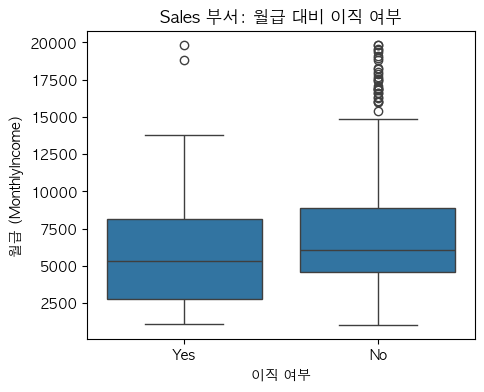

In [ ]:
# Sales 부서: 급여 수준에 따른 이직율 비교 (예시 코드)
sales = df[df['Department'] == 'Sales']
plt.figure(figsize=(5,4))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=sales)
plt.title('Sales 부서: 월급 대비 이직 여부')
plt.xlabel('이직 여부')
plt.ylabel('월급 (MonthlyIncome)')
plt.show()



[Department: Sales]
       label         비율
0    No & No  61.434978
1   No & Yes   9.865471
2   Yes & No  17.937220
3  Yes & Yes  10.762332


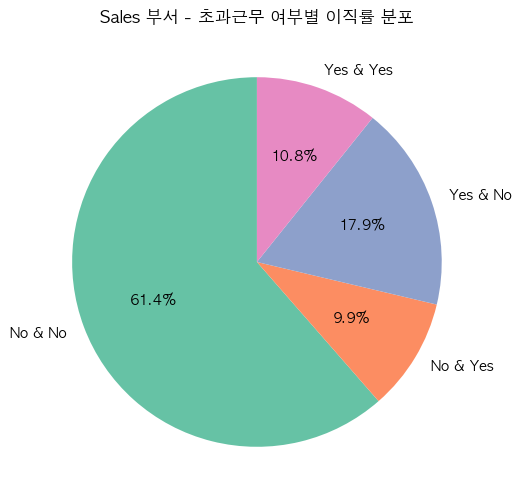


[Department: Research & Development]
       label         비율
0    No & No  65.660770
1   No & Yes   6.139438
2   Yes & No  20.499480
3  Yes & Yes   7.700312


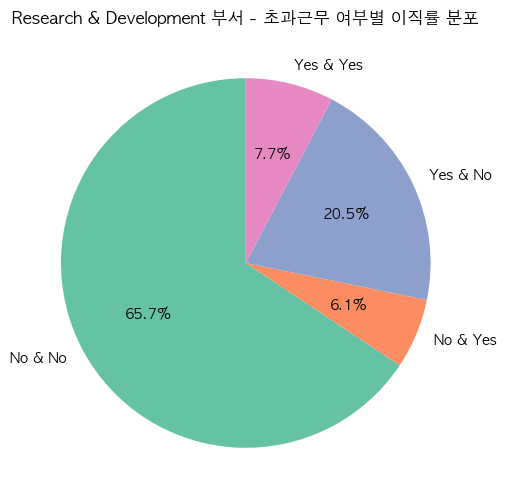


[Department: Human Resources]
       label         비율
0    No & No  61.904762
1   No & Yes  11.111111
2   Yes & No  19.047619
3  Yes & Yes   7.936508


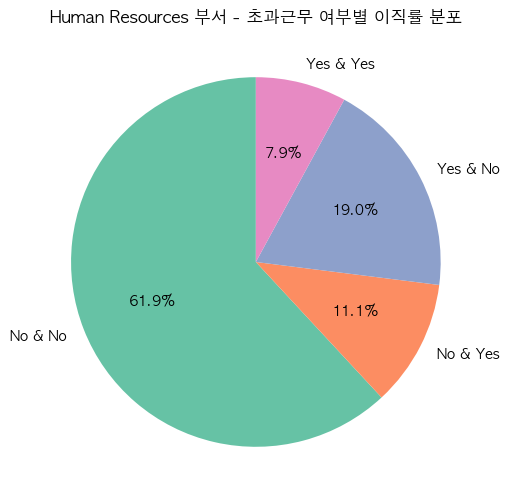

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# 색상 팔레트 (4개 조합)
colors = sns.color_palette("Set2", 4)

for dept in df["Department"].unique():
    subset = df[df["Department"] == dept]
    
    # OverTime × Attrition 조합 비율
    counts = (
        subset.groupby(["OverTime","Attrition"]).size()
        / len(subset) * 100
    ).reset_index(name="비율")
    
    # 라벨 만들기
    counts["label"] = counts["OverTime"] + " & " + counts["Attrition"]
    
    # 출력 확인
    print(f"\n[Department: {dept}]")
    print(counts[["label","비율"]])
    
    # 파이차트
    plt.figure(figsize=(6,6))
    plt.pie(
        counts["비율"],
        labels=counts["label"],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    plt.title(f"{dept} 부서 - 초과근무 여부별 이직률 분포")
    plt.show()



[Department: Sales] (OverTime=Yes 직원만)
Attrition
No     62.5
Yes    37.5
Name: proportion, dtype: float64


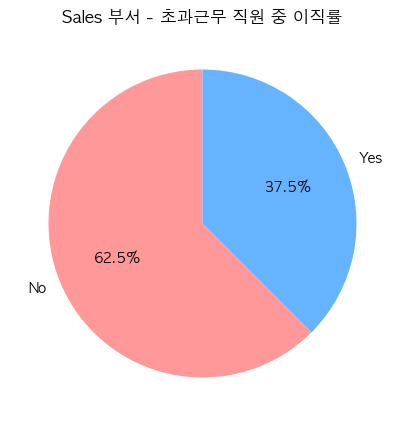


[Department: Research & Development] (OverTime=Yes 직원만)
Attrition
No     72.7
Yes    27.3
Name: proportion, dtype: float64


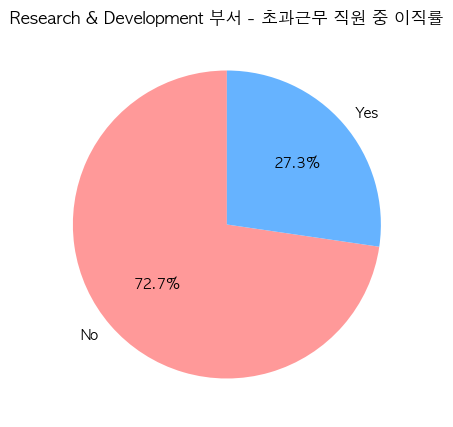


[Department: Human Resources] (OverTime=Yes 직원만)
Attrition
No     70.6
Yes    29.4
Name: proportion, dtype: float64


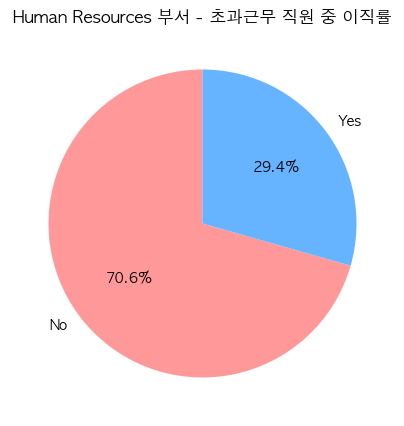

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

for dept in df["Department"].unique():
    subset = df[(df["Department"] == dept) & (df["OverTime"] == "Yes")]
    
    if len(subset) == 0:
        print(f"\n[Department: {dept}] 초과근무 직원 없음")
        continue
    
    # 이직 여부 비율
    counts = subset["Attrition"].value_counts(normalize=True) * 100
    
    # 출력 확인
    print(f"\n[Department: {dept}] (OverTime=Yes 직원만)")
    print(counts.round(1))
    
    # 원판
    plt.figure(figsize=(5,5))
    plt.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=["#ff9999","#66b3ff"]
    )
    plt.title(f"{dept} 부서 - 초과근무 직원 중 이직률")
    plt.show()



📌 각 부서별 직무 종류 분포 (직원 수)
JobRole                 Healthcare Representative  Human Resources  \
Department                                                           
Human Resources                                 0               52   
Research & Development                        131                0   
Sales                                           0                0   

JobRole                 Laboratory Technician  Manager  \
Department                                               
Human Resources                             0       11   
Research & Development                    259       54   
Sales                                       0       37   

JobRole                 Manufacturing Director  Research Director  \
Department                                                          
Human Resources                              0                  0   
Research & Development                     145                 80   
Sales                                        0           

<Figure size 1000x600 with 0 Axes>

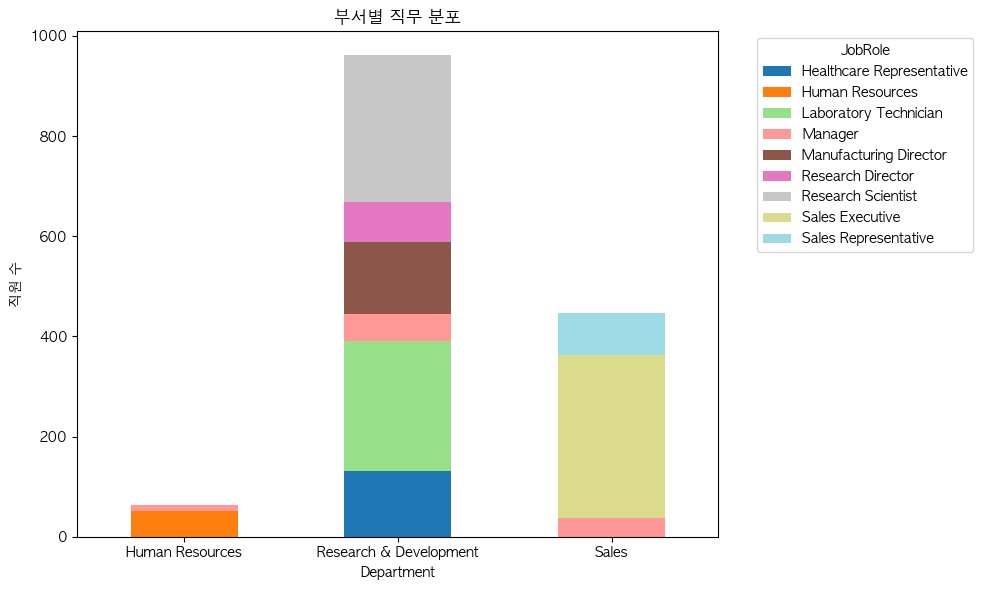

In [119]:
dept_jobrole_counts = df.groupby(["Department","JobRole"]).size().unstack(fill_value=0)
print("\n📌 각 부서별 직무 종류 분포 (직원 수)")
print(dept_jobrole_counts)

plt.figure(figsize=(10,6))
dept_jobrole_counts.plot(kind="bar", stacked=True, colormap="tab20", figsize=(10,6))
plt.title("부서별 직무 분포")
plt.ylabel("직원 수")
plt.xticks(rotation=0)
plt.legend(title="JobRole", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [122]:
import pandas as pd

# 1) 전체 직원 수
total_employees = len(df)

# 2) 전체 월급 총액
total_salary = df["MonthlyIncome"].sum()

# 3) 전체 이직률
attrition_rate_total = (df["Attrition"] == "Yes").mean() * 100

print("📌 전체 직원 수:", total_employees)
print("📌 전체 월급 총액:", total_salary)
print("📌 전체 이직률: {:.1f}%".format(attrition_rate_total))


# 4) 부서별 인원수, 총월급, 평균월급, 이직률
dept_summary = df.groupby("Department").agg(
    인원수=("EmployeeNumber", "count"),
    총월급=("MonthlyIncome", "sum"),
    평균월급=("MonthlyIncome", "mean"),
    이직률=("Attrition", lambda x: (x=="Yes").mean() * 100)
).reset_index()

print("\n📌 부서별 인원수, 총월급, 평균월급, 이직률 (%)")
print(dept_summary)

# CSV 저장
dept_summary.to_csv("department_summary.csv", index=False, encoding="utf-8-sig")


# 5) 부서별 + 직무(JobRole)별 인원수, 총월급, 평균월급, 이직률
dept_jobrole_summary = df.groupby(["Department","JobRole"]).agg(
    인원수=("EmployeeNumber","count"),
    총월급=("MonthlyIncome","sum"),
    평균월급=("MonthlyIncome","mean"),
    이직률=("Attrition", lambda x: (x=="Yes").mean() * 100)
).reset_index()

print("\n📌 부서별 직무별 인원수, 총월급, 평균월급, 이직률 (%)")
print(dept_jobrole_summary)

# CSV 저장
dept_jobrole_summary.to_csv("department_jobrole_summary.csv", index=False, encoding="utf-8-sig")


📌 전체 직원 수: 1470
📌 전체 월급 총액: 9559309
📌 전체 이직률: 16.1%

📌 부서별 인원수, 총월급, 평균월급, 이직률 (%)
               Department  인원수      총월급         평균월급        이직률
0         Human Resources   63   419234  6654.507937  19.047619
1  Research & Development  961  6036284  6281.252862  13.839750
2                   Sales  446  3103791  6959.172646  20.627803

📌 부서별 직무별 인원수, 총월급, 평균월급, 이직률 (%)
                Department                    JobRole  인원수      총월급  \
0          Human Resources            Human Resources   52   220259   
1          Human Resources                    Manager   11   198975   
2   Research & Development  Healthcare Representative  131   986268   
3   Research & Development      Laboratory Technician  259   838427   
4   Research & Development                    Manager   54   925038   
5   Research & Development     Manufacturing Director  145  1057795   
6   Research & Development          Research Director   80  1282684   
7   Research & Development         Research Scientist  292

In [123]:
import pandas as pd

# 1) 부서 + 직무 단위 요약 (총/평균 월급 + 이직률)
dept_jobrole_summary = df.groupby(["Department","JobRole"]).agg(
    인원수=("EmployeeNumber","count"),
    총월급=("MonthlyIncome","sum"),
    평균월급=("MonthlyIncome","mean"),
    이직률=("Attrition", lambda x: (x=="Yes").mean() * 100),
    
    # 이직 안한 사람 (Attrition == "No")
    이직안한_총월급=("MonthlyIncome", lambda x: df.loc[x.index][df.loc[x.index,"Attrition"]=="No"]["MonthlyIncome"].sum()),
    이직안한_평균월급=("MonthlyIncome", lambda x: df.loc[x.index][df.loc[x.index,"Attrition"]=="No"]["MonthlyIncome"].mean()),
    
    # 이직한 사람 (Attrition == "Yes")
    이직한_총월급=("MonthlyIncome", lambda x: df.loc[x.index][df.loc[x.index,"Attrition"]=="Yes"]["MonthlyIncome"].sum()),
    이직한_평균월급=("MonthlyIncome", lambda x: df.loc[x.index][df.loc[x.index,"Attrition"]=="Yes"]["MonthlyIncome"].mean())
).reset_index()

# 결과 확인
print(dept_jobrole_summary.head())

# CSV 저장
dept_jobrole_summary.to_csv("department_jobrole_salary_summary.csv", index=False, encoding="utf-8-sig")


               Department                    JobRole  인원수     총월급  \
0         Human Resources            Human Resources   52  220259   
1         Human Resources                    Manager   11  198975   
2  Research & Development  Healthcare Representative  131  986268   
3  Research & Development      Laboratory Technician  259  838427   
4  Research & Development                    Manager   54  925038   

           평균월급        이직률  이직안한_총월급     이직안한_평균월급  이직한_총월급      이직한_평균월급  
0   4235.750000  23.076923    175670   4391.750000    44589   3715.750000  
1  18088.636364   0.000000    198975  18088.636364        0           NaN  
2   7528.763359   6.870229    909334   7453.557377    76934   8548.222222  
3   3237.169884  23.938224    657433   3337.223350   180994   2919.258065  
4  17130.333333   5.555556    879720  17249.411765    45318  15106.000000  


In [121]:
import pandas as pd

# 1) 전체 직원 수
total_employees = len(df)

# 2) 전체 월급 총액
total_salary = df["MonthlyIncome"].sum()

# 3) 전체 이직률
attrition_rate_total = (df["Attrition"] == "Yes").mean() * 100

print("📌 전체 직원 수:", total_employees)
print("📌 전체 월급 총액:", total_salary)
print("📌 전체 이직률: {:.1f}%".format(attrition_rate_total))


# 4) 부서별 인원수, 총월급, 평균월급, 이직률
dept_summary = df.groupby("Department").agg(
    인원수=("EmployeeNumber", "count"),
    총월급=("MonthlyIncome", "sum"),
    평균월급=("MonthlyIncome", "mean"),
    이직률=("Attrition", lambda x: (x=="Yes").mean() * 100)
).reset_index()

print("\n📌 부서별 인원수, 총월급, 평균월급, 이직률 (%)")
print(dept_summary)


# 5) 부서별 + 직무(JobRole)별 인원수, 총월급, 평균월급, 이직률
dept_jobrole_summary = df.groupby(["Department","JobRole"]).agg(
    인원수=("EmployeeNumber","count"),
    총월급=("MonthlyIncome","sum"),
    평균월급=("MonthlyIncome","mean"),
    이직률=("Attrition", lambda x: (x=="Yes").mean() * 100)
).reset_index()

print("\n📌 부서별 직무별 인원수, 총월급, 평균월급, 이직률 (%)")
print(dept_jobrole_summary)


📌 전체 직원 수: 1470
📌 전체 월급 총액: 9559309
📌 전체 이직률: 16.1%

📌 부서별 인원수, 총월급, 평균월급, 이직률 (%)
               Department  인원수      총월급         평균월급        이직률
0         Human Resources   63   419234  6654.507937  19.047619
1  Research & Development  961  6036284  6281.252862  13.839750
2                   Sales  446  3103791  6959.172646  20.627803

📌 부서별 직무별 인원수, 총월급, 평균월급, 이직률 (%)
                Department                    JobRole  인원수      총월급  \
0          Human Resources            Human Resources   52   220259   
1          Human Resources                    Manager   11   198975   
2   Research & Development  Healthcare Representative  131   986268   
3   Research & Development      Laboratory Technician  259   838427   
4   Research & Development                    Manager   54   925038   
5   Research & Development     Manufacturing Director  145  1057795   
6   Research & Development          Research Director   80  1282684   
7   Research & Development         Research Scientist  292

In [124]:
import pandas as pd

# 부서+직무 단위 요약
dept_jobrole_summary = df.groupby(["Department","JobRole"]).apply(
    lambda g: pd.Series({
        "총인원수": len(g),
        "총월급": g["MonthlyIncome"].sum(),
        "평균월급": g["MonthlyIncome"].mean(),
        
        # 잔류자
        "잔류인원수": (g["Attrition"]=="No").sum(),
        "잔류_총월급": g.loc[g["Attrition"]=="No","MonthlyIncome"].sum(),
        "잔류_평균월급": g.loc[g["Attrition"]=="No","MonthlyIncome"].mean(),
        
        # 이직자
        "이직인원수": (g["Attrition"]=="Yes").sum(),
        "이직_총월급": g.loc[g["Attrition"]=="Yes","MonthlyIncome"].sum(),
        "이직_평균월급": g.loc[g["Attrition"]=="Yes","MonthlyIncome"].mean(),
        
        # 이직률
        "이직률(%)": (g["Attrition"]=="Yes").mean() * 100
    })
).reset_index()

# 확인
print(dept_jobrole_summary.head())

# CSV 저장
dept_jobrole_summary.to_csv("department_jobrole_salary_summary.csv", index=False, encoding="utf-8-sig")


               Department                    JobRole   총인원수       총월급  \
0         Human Resources            Human Resources   52.0  220259.0   
1         Human Resources                    Manager   11.0  198975.0   
2  Research & Development  Healthcare Representative  131.0  986268.0   
3  Research & Development      Laboratory Technician  259.0  838427.0   
4  Research & Development                    Manager   54.0  925038.0   

           평균월급  잔류인원수    잔류_총월급       잔류_평균월급  이직인원수    이직_총월급       이직_평균월급  \
0   4235.750000   40.0  175670.0   4391.750000   12.0   44589.0   3715.750000   
1  18088.636364   11.0  198975.0  18088.636364    0.0       0.0           NaN   
2   7528.763359  122.0  909334.0   7453.557377    9.0   76934.0   8548.222222   
3   3237.169884  197.0  657433.0   3337.223350   62.0  180994.0   2919.258065   
4  17130.333333   51.0  879720.0  17249.411765    3.0   45318.0  15106.000000   

      이직률(%)  
0  23.076923  
1   0.000000  
2   6.870229  
3  23.938224  

In [125]:
import pandas as pd

# 부서+직무 단위 요약
dept_jobrole_summary = df.groupby(["Department","JobRole"]).apply(
    lambda g: pd.Series({
        "총인원수": len(g),
        "총월급": g["MonthlyIncome"].sum(),
        "평균월급": g["MonthlyIncome"].mean(),
        
        # 잔류자
        "잔류인원수": (g["Attrition"]=="No").sum(),
        "잔류_총월급": g.loc[g["Attrition"]=="No","MonthlyIncome"].sum(),
        "잔류_평균월급": g.loc[g["Attrition"]=="No","MonthlyIncome"].mean(),
        
        # 이직자
        "이직인원수": (g["Attrition"]=="Yes").sum(),
        "이직_총월급": g.loc[g["Attrition"]=="Yes","MonthlyIncome"].sum(),
        "이직_평균월급": g.loc[g["Attrition"]=="Yes","MonthlyIncome"].mean(),
        
        # 전체 이직률
        "이직률(%)": (g["Attrition"]=="Yes").mean() * 100,
        
        # 초과근무자 이직률
        "OT_Yes_이직률(%)": (
            (g.loc[g["OverTime"]=="Yes","Attrition"]=="Yes").mean() * 100
            if (g["OverTime"]=="Yes").any() else None
        ),
        
        # 초과근무 없는 직원 이직률
        "OT_No_이직률(%)": (
            (g.loc[g["OverTime"]=="No","Attrition"]=="Yes").mean() * 100
            if (g["OverTime"]=="No").any() else None
        )
    })
).reset_index()

# 확인
print(dept_jobrole_summary.head())

# CSV 저장
dept_jobrole_summary.to_csv("department_jobrole_salary_summary.csv", index=False, encoding="utf-8-sig")


               Department                    JobRole   총인원수       총월급  \
0         Human Resources            Human Resources   52.0  220259.0   
1         Human Resources                    Manager   11.0  198975.0   
2  Research & Development  Healthcare Representative  131.0  986268.0   
3  Research & Development      Laboratory Technician  259.0  838427.0   
4  Research & Development                    Manager   54.0  925038.0   

           평균월급  잔류인원수    잔류_총월급       잔류_평균월급  이직인원수    이직_총월급       이직_평균월급  \
0   4235.750000   40.0  175670.0   4391.750000   12.0   44589.0   3715.750000   
1  18088.636364   11.0  198975.0  18088.636364    0.0       0.0           NaN   
2   7528.763359  122.0  909334.0   7453.557377    9.0   76934.0   8548.222222   
3   3237.169884  197.0  657433.0   3337.223350   62.0  180994.0   2919.258065   
4  17130.333333   51.0  879720.0  17249.411765    3.0   45318.0  15106.000000   

      이직률(%)  OT_Yes_이직률(%)  OT_No_이직률(%)  
0  23.076923      38.461538   

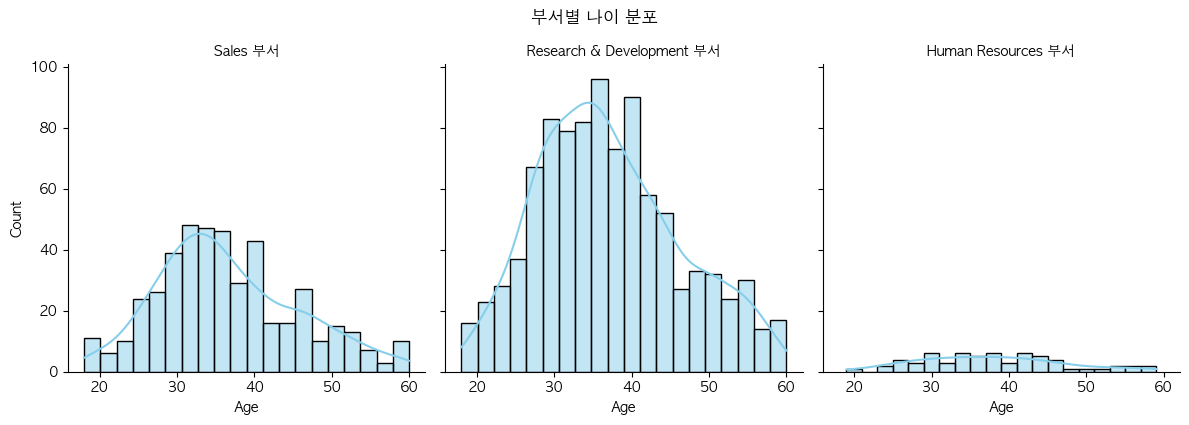

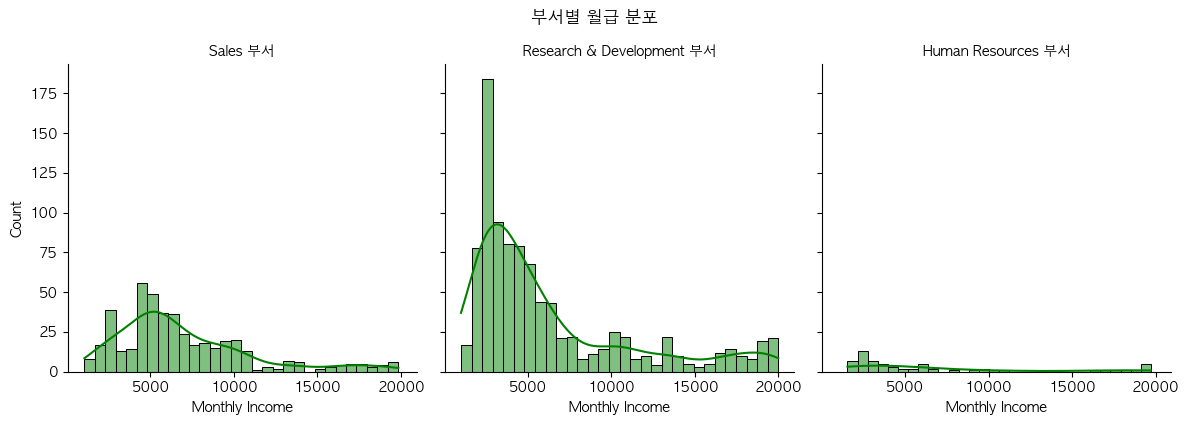

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# 부서별 나이 분포
g = sns.FacetGrid(df, col="Department", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, "Age", bins=20, kde=True, color="skyblue")
g.set_titles(col_template="{col_name} 부서")
g.set_axis_labels("Age", "Count")
plt.suptitle("부서별 나이 분포", y=1.05)
plt.show()

# 부서별 월급 분포
g = sns.FacetGrid(df, col="Department", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, "MonthlyIncome", bins=30, kde=True, color="green")
g.set_titles(col_template="{col_name} 부서")
g.set_axis_labels("Monthly Income", "Count")
plt.suptitle("부서별 월급 분포", y=1.05)
plt.show()
